In [1]:
import numpy as np
import analysis_utilities as au
import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb


In [2]:
from numba import njit
import numpy as np

@njit
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result

@njit
def nb_nanstd(array, axis):
    return np_apply_along_axis(np.nanstd, axis, array)

@njit
def nb_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)

@njit
def nb_nanmean(array, axis):
    return np_apply_along_axis(np.nanmean, axis, array)

In [10]:
@nb.njit
def one_way_rm_anova(data):
    grand_n = len(data.flatten()) # Total number of datapoints
    n_i = data.shape[1] # Number of datapoints for each group, doesn't have to be equal for all groups but usually is
    m = data.shape[0] # Total number of groups 
    grand_mean = np.mean(data)
    group_means = nb_mean(data,axis=1)
    subject_means = nb_mean(data,axis=0)
    ss_total = np.sum((data.flatten() - grand_mean)**2)
    ss_group = np.sum(n_i*(group_means - grand_mean)**2)
    ss_subjects = m*np.sum((subject_means - grand_mean)**2)
    
    ss_error = ss_total - ss_group - ss_subjects
    ms_group = ss_group/(m - 1)
    ms_error = ss_error/((n_i-1)*(m-1))
    
    f_statistic = ms_group/ms_error
    return f_statistic

@nb.njit
def boostrap_rm_anova(data, alternative = 'two-sided', M = 1e5):
    f_store = np.zeros(int(M))
    M = int(M)
    original_f = one_way_anova(data)
    data_len = data.shape[1]
    for i in nb.prange(M):

        indices = np.random.choice(np.arange(0,data_len,1), size = data_len, replace=True)
        data_boot = data[:,indices]     
    
        assert np.all(data[:,indices[0]] == data_boot[:,0])
        grand_n = len(data.flatten()) # Total number of datapoints
        n_i = data.shape[1] # Number of datapoints for each group, doesn't have to be equal for all groups but usually is
        m = data.shape[0] # Total number of groups 
        grand_mean = np.mean(data_boot)
        group_means = nb_mean(data_boot,axis=1)
        subject_means = nb_mean(data_boot,axis=0)
        ss_total = np.sum((data_boot.flatten() - grand_mean)**2)
        ss_group = np.sum(n_i*(group_means - grand_mean)**2)
        ss_subjects = m*np.sum((subject_means - grand_mean)**2)
        
        ss_error = ss_total - ss_group - ss_subjects
        ms_group = ss_group/(m - 1)
        ms_error = ss_error/((n_i-1)*(m-1))
        f_statistic = ms_group/ms_error
        f_store[i] = one_way_anova(data_boot)
    
    centered_results = f_store - original_f
    
    #are the results more extreme than the original?
    p_val = np.sum(centered_results > abs(original_f)) + np.sum(centered_results < -abs(original_f))
    returned_distribution = centered_results
    
    return p_valf_store

In [11]:
np.random.seed(0)
group_1 = np.random.normal(0, 4, 60)
group_2 = np.random.normal(4, 4, 60)
group_3 = np.random.normal(4, 4, 60)
# group_1 = np.arange(0,10,1)
# group_2 = np.arange(0,10,1)
data = np.vstack((group_1, group_2))
one_way_anova(data)

30.988285468448627

In [12]:
result = boostrap_rm_anova(data,M=1e3)


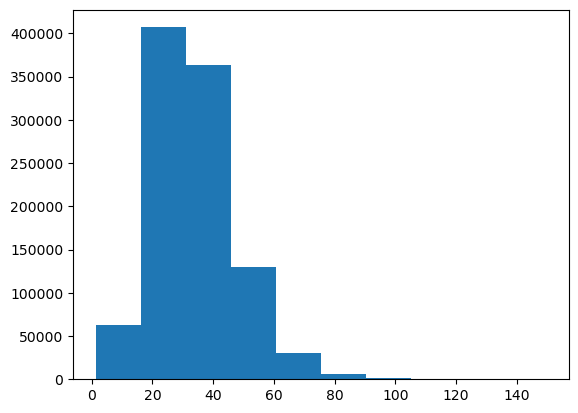

In [8]:
fig,ax = plt.subplots()
ax.hist(result)
plt.show()

In [ ]:
subject_num = np.tile(np.arange(group_1.shape[0], dtype=int),data.shape[0])
treatment_num = np.repeat([0,1],60)
data_ = np.vstack((subject_num,treatment_num,data.flatten()))
df_data = pd.DataFrame(data_.T, columns = ['Subject','Treatment', 'Values'])
df_data.head()

,Subject,Treatment,Values
0,0.0,0.0,7.056209
1,1.0,0.0,1.600629
2,2.0,0.0,3.914952
3,3.0,0.0,8.963573
4,4.0,0.0,7.470232


In [ ]:
pg.rm_anova(df_data, dv='Values', within='Treatment',subject='Subject')

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Treatment,1,59,30.988285,6.685840e-07,0.221035,1.0


In [14]:
df = pg.read_dataset('rm_anova')


In [15]:
df.head()

,Subject,Gender,Region,Education,DesireToKill,Disgustingness,Frighteningness
0,1,Female,North,some,10.0,High,High
1,1,Female,North,some,9.0,High,Low
2,1,Female,North,some,6.0,Low,High
3,1,Female,North,some,6.0,Low,Low
4,2,Female,North,advance,10.0,High,High


In [17]:
pg.rm_anova(df, dv= 'DesireToKill', within=['Disgustingness', 'Frighteningness'], subject='Subject')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Disgustingness,48.752841,1,87,48.752841,12.175190,7.623808e-04,7.623808e-04,0.018554,1.0
1,Frighteningness,177.556818,1,87,177.556818,41.629663,6.011447e-09,6.011447e-09,0.064415,1.0
2,Disgustingness * Frighteningness,6.545455,1,87,6.545455,2.152300,1.459622e-01,1.459622e-01,0.002532,1.0
